In [ ]:
DBFILE = "allblocks-istanbul-crux-docker-1s-gas20mio-RPC_run8.db"
NAME_PREFIX="istanbul-crux-docker-1s-gas20mio-RPC_run8"

# analyze `allblocks-istanbul-crux-docker-1s-gas20mio-RPC_run8.db` data

calculates & plots

* blocktime
* TPS (transactions per second), over 1, 3, 5, 10 consecutive blocks
* block size
* gasUsed and gasLimit per second

It needs an `allblocks-....db` database (created by `blocksDB_create.py`) containing all the blocks.

In this specific case the "Quorum" client of the EEA, and the `IBFT` variant with `dockerized crux 4 nodes`, with large enough `gasLimit 20 million`, 13 multithreading workers - and not going through web3 but instead *directly sending the transactions via RPC calls* to one of the 4 nodes. 

---

Please cite this as:

> Ethereum benchmarking scripts "chainhammer" and "chainreader"  
> by Dr Andreas Krueger, Electron.org.uk, London 2018  
> https://github.com/drandreaskrueger/chainhammer    

Consider to submit your improvements & usage as pull request --> [../other-projects.md](../other-projects.md).  Thanks.


---

<a id='chainhammer1000'>10000 TPS shot at the Quorum-Istanbul node</a>
# my own experiment: 
## 10000 transactions submitted with `chainhammer` 


    


## TOC

Code 

* [import from database](#Database)
* [simple statistics](#stats)
* [generate new columns](#columns)
* [4 diagrams in one](#code4diagrams)

Results

* [tables of peak TPS rates](#tables)
* [all 3 consecutive experiments](#allExperiments)
* [experiment 1](#experiment 1)
* [experiment 3](#experiment 3)


<a id='database'>Database</a>

In [ ]:
#dependencies

import sqlite3; print("sqlite3 version", sqlite3.version)
import pandas; print("pandas version", pandas.__version__)
import numpy; print("numpy version", numpy.__version__)
import matplotlib; print("matplotlib version", matplotlib.__version__)

%matplotlib inline

# https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
matplotlib.rcParams['agg.path.chunksize'] = 10000

print ("\nReading blocks table from", DBFILE)

sqlite3 version 2.6.0
pandas version 0.23.0
numpy version 1.14.4
matplotlib version 2.2.2

Reading blocks table from allblocks-istanbul-crux-docker-1s-gas20mio-RPC_run8.db


### TODO: refactoring
all the following functions could go into a separate `blocksDB_diagramming.py` for better recycling.

**For now, please simply scroll down.**

In [ ]:
# open database connection
conn = sqlite3.connect(DBFILE)

# any SQL query 

def DB_query(SQL, conn):
    cur = conn.cursor()
    cur.execute(SQL)
    result = cur.fetchall()
    return result

print ("DB table names: ", DB_query("SELECT name FROM sqlite_master WHERE type='table';", conn)[0])

# number of rows?

def DB_tableSize(tablename, conn):
    """
    prints number of rows
    """
    count = DB_query("SELECT COUNT(*) FROM %s" % tablename, conn)
    print ("TABLE %s has %d rows" % (tablename, count[0][0]))
    return count
_=DB_tableSize("blocks", conn)

# what is the first & last block we have?

def maxBlockNumber(conn):
    result = DB_query("SELECT MIN(blocknumber), MAX(blocknumber) FROM blocks", conn)
    print ("MIN(blocknumber), MAX(blocknumber) = %s " % (result) )
    return result
minblock, maxblock = maxBlockNumber(conn)[0]

DB table names:  ('blocks',)
TABLE blocks has 123 rows
MIN(blocknumber), MAX(blocknumber) = [(0, 122)] 


In [ ]:
blocknumbers = DB_query("SELECT blocknumber FROM blocks ORDER BY blocknumber", conn) 
print ("len(blocknumbers)=", len(blocknumbers))

len(blocknumbers)= 123


In [ ]:
# do we have consecutive blocks, none missing?

def check_whether_complete(blocknumbers):
    start = min(blocknumbers)[0]
    last = max(blocknumbers)[0]
    old = start-1
    total=0
    for bn in blocknumbers:
        bn = bn[0]
        missing=bn-old-1
        if missing>0:
            print ("from ", old+1, "to", bn - 1, "there are ", missing, " missing")
            total+=missing
        old = bn
    print()
    print ("complete" if not total else "some %d blocks missing" % total, end=" ")
    print ("between blocks %d and %d." %(min(blocknumbers)[0], max(blocknumbers)[0]))
    
check_whether_complete(blocknumbers)


complete between blocks 0 and 122.


<a id='stats'>simple statistics</a>

In [ ]:
# simple statistics

size_max = DB_query("SELECT MAX(size) FROM blocks", conn); print ("(block)size_max", size_max[0][0])
txcount_max = DB_query("SELECT MAX(txcount) FROM blocks", conn); print ("txcount_max", txcount_max[0][0])
txcount_av = DB_query("SELECT AVG(txcount) FROM blocks", conn); print ("txcount_av", txcount_av[0][0])
txcount_sum = DB_query("SELECT SUM(txcount) FROM blocks", conn); print ("txcount_sum", txcount_sum[0][0])
blocks_nonempty_count = DB_query("SELECT COUNT(blocknumber) FROM blocks WHERE txcount != 0", conn); print ("blocks_nonempty_count", blocks_nonempty_count[0][0])
print ("av tx per nonempty blocks = ", txcount_sum[0][0] / blocks_nonempty_count[0][0] )

(block)size_max 81633
txcount_max 585
txcount_av 162.609756097561
txcount_sum 20001
blocks_nonempty_count 54
av tx per nonempty blocks =  370.3888888888889


<a id='colums'>new columns</a>
## read whole table, and create new columns

In [ ]:
# read whole table

# SQL="SELECT * FROM blocks WHERE 48500<blocknumber and blocknumber<49000 ORDER BY blocknumber"
SQL="SELECT * FROM blocks ORDER BY blocknumber"
df = pandas.read_sql(SQL, conn)

In [ ]:
conn.close()

### `geth` based clients have a nanosecond timestamp

not anymore?

In [ ]:
# transform nanoseconds to seconds
# df["timestamp"]=df["timestamp"]/1000000000
df[0:10]


,blocknumber,timestamp,size,gasUsed,gasLimit,txcount
0,0,1533565005,698,0,20000000,0
1,1,1534430209,902,0,20004881,0
2,2,1534430219,902,0,20009764,0
3,3,1534430220,902,0,20014648,0
4,4,1534430221,902,0,20019533,0
5,5,1534430230,902,0,20024419,0
6,6,1534430231,902,0,20029306,0
7,7,1534430232,902,0,20034194,0
8,8,1534430241,902,0,20039084,0
9,9,1534430242,902,0,20043975,0


In [ ]:
# blocktime = timestamp[n] - timestamp[n-1]

def add_blocktime(df):
    df['blocktime'] = df['timestamp'] - df['timestamp'].shift()
    df.loc[1, "blocktime"] = numpy.nan
    
add_blocktime(df)


In [ ]:
#df["TPS_1"]=df['txcount']/df['blocktime']
#df

In [ ]:
# transactions per second
# with differently sized (rectangular) windows

def add_TPS(df, numBlocks):
    name = 'TPS_%dblks'%numBlocks if numBlocks>1 else 'TPS_%dblk'%numBlocks
    df[name]=df['txcount'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()
    
add_TPS(df, numBlocks=1)
add_TPS(df, numBlocks=3)
add_TPS(df, numBlocks=5)
add_TPS(df, numBlocks=10)

In [ ]:
# gasUsed and gasLimit per second

def add_GUPS(df, numBlocks):
    name = 'GUPS_%dblks'%numBlocks if numBlocks>1 else 'GUPS_%dblk'%numBlocks
    df[name]=df['gasUsed'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

def add_GLPS(df, numBlocks):
    name = 'GLPS_%dblks'%numBlocks if numBlocks>1 else 'GLPS_%dblk'%numBlocks
    df[name]=df['gasLimit'].rolling(numBlocks).sum() / df['blocktime'].rolling(numBlocks).sum()

add_GUPS(df, numBlocks=1)
add_GUPS(df, numBlocks=3)
add_GUPS(df, numBlocks=5)

add_GLPS(df, numBlocks=1)
add_GLPS(df, numBlocks=3)
add_GLPS(df, numBlocks=5)

<a id='tables'>tables of peak TPS rates</a>
## peak TPS rates

In [ ]:
# peak TPS single block

df.sort_values(by=['TPS_1blk'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
45,45,1534430283,81633,15614235,20220843,585,1.0,585.0,491.333333,485.4,478.9,15614235.0,13114178.0,12955811.4,20220843.0,2.021591e+07,20210977.2
31,31,1534430269,78553,15027033,20151876,563,1.0,563.0,258.666667,155.4,77.7,15027033.0,6909072.0,4170877.8,20151876.0,2.014696e+07,20142044.0
57,57,1534430295,77629,14840196,20280144,556,1.0,556.0,479.333333,474.0,466.4,14840196.0,12793886.0,12651534.0,20280144.0,2.027520e+07,20270250.0
53,53,1534430291,76245,14573286,20260358,546,1.0,546.0,484.000000,473.4,472.8,14573286.0,12918444.0,12635519.4,20260358.0,2.025541e+07,20250473.2
33,33,1534430271,73074,13959393,20161714,523,1.0,523.0,531.666667,361.6,180.9,13959393.0,14190715.0,9654465.6,20161714.0,2.015679e+07,20151877.2
32,32,1534430270,71145,13585719,20156794,509,1.0,509.0,428.333333,257.2,128.6,13585719.0,11437645.0,6888021.6,20156794.0,2.015188e+07,20146960.0
52,52,1534430290,70455,13452264,20255414,504,1.0,504.0,455.333333,458.8,463.6,13452264.0,12153302.0,12245830.8,20255414.0,2.025047e+07,20245532.0
37,37,1534430275,70454,13452264,20181404,504,1.0,504.0,472.333333,466.6,361.9,13452264.0,12607049.0,12454020.6,20181404.0,2.017648e+07,20171558.0
41,41,1534430279,69077,13185354,20201114,494,1.0,494.0,473.666667,477.8,472.7,13185354.0,12642637.0,12752959.8,20201114.0,2.019619e+07,20191258.0
40,40,1534430278,68114,12998517,20196185,487,1.0,487.0,463.666667,472.4,479.6,12998517.0,12375727.0,12608828.4,20196185.0,2.019126e+07,20186331.2


In [ ]:
# peak TPS over ten blocks

df.sort_values(by=['TPS_10blks'], ascending=False)[0:10]

,blocknumber,timestamp,size,gasUsed,gasLimit,txcount,blocktime,TPS_1blk,TPS_3blks,TPS_5blks,TPS_10blks,GUPS_1blk,GUPS_3blks,GUPS_5blks,GLPS_1blk,GLPS_3blks,GLPS_5blks
40,40,1534430278,68114,12998517,20196185,487,1.0,487.0,463.666667,472.4,479.6,12998517.0,12375727.0,12608828.4,20196185.0,2.019126e+07,20186331.2
45,45,1534430283,81633,15614235,20220843,585,1.0,585.0,491.333333,485.4,478.9,15614235.0,13114178.0,12955811.4,20220843.0,2.021591e+07,20210977.2
46,46,1534430284,63140,12037641,20225778,451,1.0,451.0,490.333333,476.8,477.3,12037641.0,13087487.0,12726268.8,20225778.0,2.022084e+07,20215910.0
53,53,1534430291,76245,14573286,20260358,546,1.0,546.0,484.000000,473.4,472.8,14573286.0,12918444.0,12635519.4,20260358.0,2.025541e+07,20250473.2
41,41,1534430279,69077,13185354,20201114,494,1.0,494.0,473.666667,477.8,472.7,13185354.0,12642637.0,12752959.8,20201114.0,2.019619e+07,20191258.0
49,49,1534430287,63688,12144405,20240591,455,1.0,455.0,448.333333,476.2,471.0,12144405.0,11966465.0,12710254.2,20240591.0,2.023565e+07,20230715.6
48,48,1534430286,66176,12624843,20235652,473,1.0,473.0,447.000000,472.2,469.5,12624843.0,11930877.0,12603490.2,20235652.0,2.023071e+07,20225779.2
47,47,1534430285,58449,11130147,20230714,417,1.0,417.0,484.333333,468.4,468.6,11130147.0,12927341.0,12502064.4,20230714.0,2.022578e+07,20220844.0
50,50,1534430288,64381,12277860,20245531,460,1.0,460.0,462.666667,451.2,468.3,12277860.0,12349036.0,12042979.2,20245531.0,2.024059e+07,20235653.2
54,54,1534430292,54167,10302726,20265303,386,1.0,386.0,478.666667,459.6,467.9,10302726.0,12776092.0,12267183.6,20265303.0,2.026036e+07,20255415.6


<a id='code4diagrams'>code: 4 diagrams in one</a>
## all 4 diagrams in one

In [ ]:
def diagrams(df, blockFrom, blockTo, prefix="", gas_logy=True, bt_logy=True):
    
    # https://github.com/matplotlib/matplotlib/issues/5907#issuecomment-179001811
    matplotlib.rcParams['agg.path.chunksize'] = 10000
    
    # prepare 2x2 subplots
    plt = matplotlib.pyplot
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
    plt.tight_layout(pad=6.0, w_pad=6.0, h_pad=7.5)
    title = prefix + " blocks %d to %d" % (blockFrom, blockTo)
    plt.suptitle(title, fontsize=16)
    
    # bar charts are too expensive when too many blocks
    numBlocks =  blockTo - blockFrom
    kind = 'bar' if numBlocks<2000 else 'line'
    
    # TPS averages --> legend
    cols=['TPS_1blk', 'TPS_3blks', 'TPS_5blks', 'TPS_10blks']
    averages=df[cols][blockFrom:blockTo].mean()
    legend = [col + " (av %.1f)" % averages[col] for col in cols]
    # print (legend)
    
    # TPS diagram
    cols = ['blocknumber'] + cols
    ax=df[cols][blockFrom:blockTo].plot(x='blocknumber', rot=90, ax=axes[0,0])
    ax.set_title("transactions per second")
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.legend(legend);
    
    # BT
    ax=df[['blocknumber', 'blocktime']][blockFrom:blockTo].plot(x='blocknumber', kind=kind, ax=axes[0,1],
                                                               logy=bt_logy)
    ax.set_title("blocktime since last block")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
        
    # blocksize
    ax=df[['blocknumber', 'size']][blockFrom:blockTo].plot(x='blocknumber', rot=90, kind=kind, ax=axes[1,0])
    # ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("blocksize in bytes")
    ax.locator_params(nbins=1, axis='x')  # TODO: Something is broken with matplotlib's ticks machinery
    
    # gas
    ax=df[['blocknumber', 'GLPS_1blk', 'GUPS_1blk']][blockFrom:blockTo].plot(x='blocknumber', 
                                                                             rot=90, ax=axes[1,1], 
                                                                             logy=gas_logy)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    if not gas_logy:
        ax.get_yaxis().get_major_formatter().set_scientific(False)
    ax.set_title("gasUsed and gasLimit per second")
    
    # save diagram to PNG file
    fig.savefig("img/%s_tps-bt-bs-gas_blks%d-%d.png" % (prefix,blockFrom,blockTo))


# <a id='allExperiments'>whole chain</a>


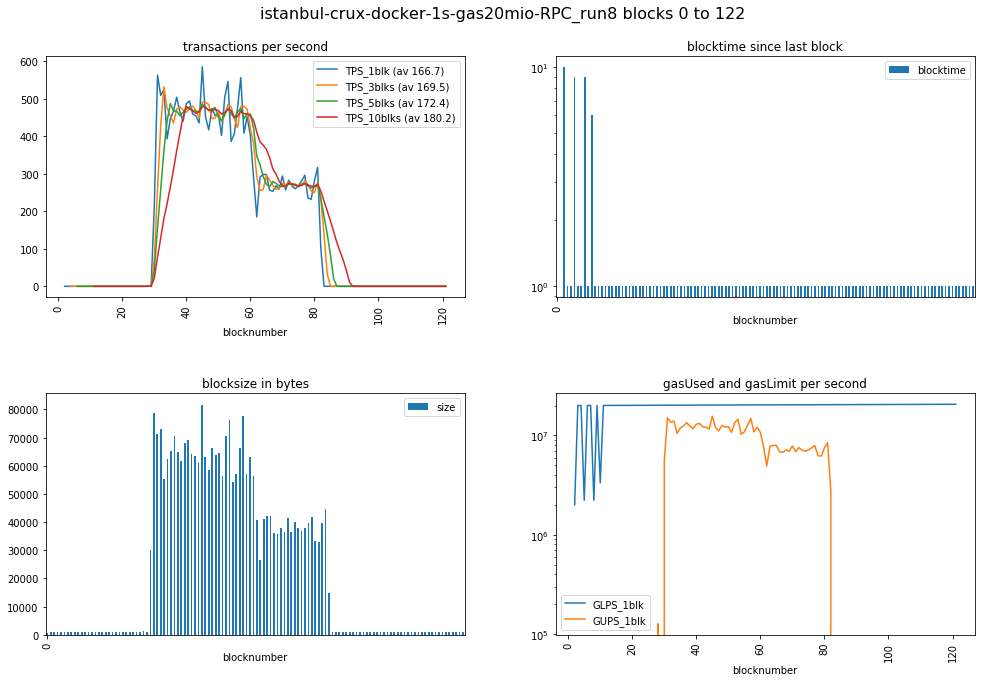

In [ ]:
# the whole range of blocks

diagrams(df, 0, len(blocknumbers)-1, NAME_PREFIX, gas_logy=True, bt_logy=True)

<a id='experiment1'>zoom in on one experiment</a>

# final experiment ...


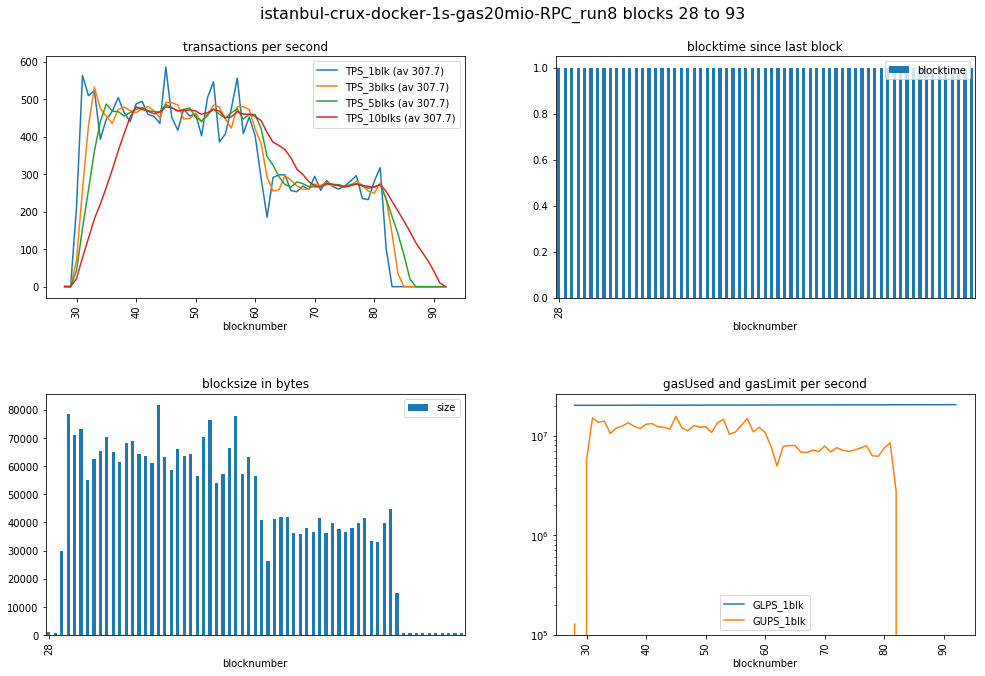

In [ ]:
# starting only at block xx because the waiting time before experiment start

diagrams(df, 28, 93, NAME_PREFIX, gas_logy=True, bt_logy=False)

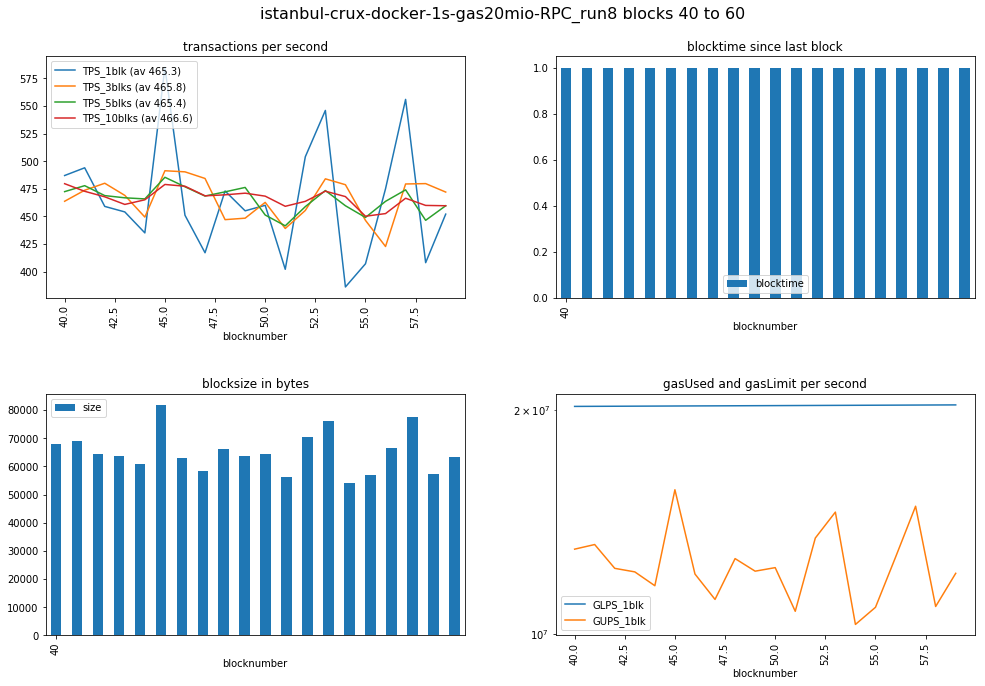

In [ ]:
diagrams(df, 40, 60, NAME_PREFIX, gas_logy=True, bt_logy=False)

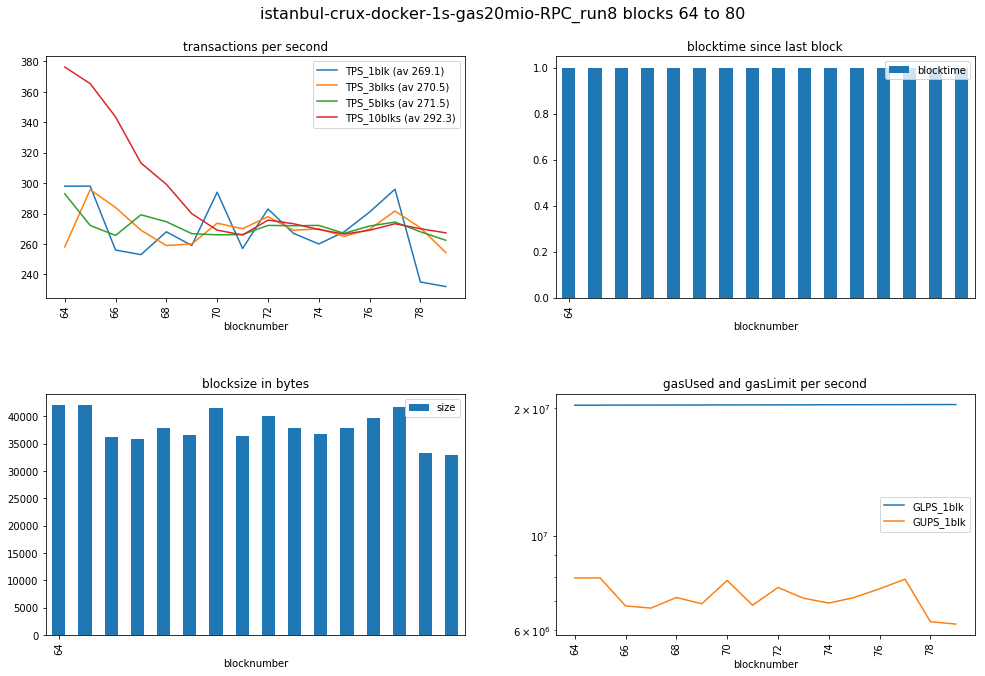

In [ ]:
diagrams(df, 64, 80, NAME_PREFIX, gas_logy=True, bt_logy=False)